# IST - DBM2: DATA MINING
*ANA ISABEL LOPEZ AND DAVID PARDO*

In [1]:
import pandas as pd
import markdown
import pytz
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import random
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from six import StringIO
from PIL import Image
import math
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import plot_tree

**PRE-PROCESSING II AND CLASSIFICATION**

As for the classification process, we do it after clustering, using the same pre-processing steps but making some changes. We simply remove maximum and minimum temperatures, and rain_3h from the outset. Additionally, we create a classification based on the wind direction in degrees (North, Northwest, Northeast, etc.), aiming to easily identify the direction, although we might not use this value later. Finally, we eliminate the grouping (groupby) to achieve a simpler preprocessing

In [2]:
weather = pd.read_csv('weather_features.csv',header='infer')
df = pd.DataFrame(weather)

In [3]:
#REMOVE INNECESARY DATA -->  weather_id, weather_icon, tem_min, temp_max, rain_3h
df = df.drop('weather_id', axis = 1)
df = df.drop('weather_icon', axis = 1)
df = df.drop('weather_description', axis = 1)
df = df.drop('temp_min',axis=1)
df = df.drop('temp_max',axis=1)
df = df.drop('rain_3h',axis=1)
df

,dt_iso,city_name,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all,weather_main
0,2015-01-01 00:00:00,Valencia,270.475,1001,77,1,62,0.0,0.0,0,clear
1,2015-01-01 01:00:00,Valencia,270.475,1001,77,1,62,0.0,0.0,0,clear
2,2015-01-01 02:00:00,Valencia,269.686,1002,78,0,23,0.0,0.0,0,clear
3,2015-01-01 03:00:00,Valencia,269.686,1002,78,0,23,0.0,0.0,0,clear
4,2015-01-01 04:00:00,Valencia,269.686,1002,78,0,23,0.0,0.0,0,clear
...,...,...,...,...,...,...,...,...,...,...,...
178391,2018-12-31 19:00:00,Seville,287.760,1028,54,3,30,0.0,0.0,0,clear
178392,2018-12-31 20:00:00,Seville,285.760,1029,62,3,30,0.0,0.0,0,clear
178393,2018-12-31 21:00:00,Seville,285.150,1028,58,4,50,0.0,0.0,0,clear
178394,2018-12-31 22:00:00,Seville,284.150,1029,57,4,60,0.0,0.0,0,clear


In [4]:
#We create a DataFrame
df['dt_iso'] = pd.to_datetime(df['dt_iso'], format='%Y-%m-%d %H:%M:%S', utc=True)  # Convertir la columna a tipo datetime

#We split the date into year, day, month, and hour. 
df['year'] = df['dt_iso'].dt.year
df['month'] = df['dt_iso'].dt.month
df['day'] = df['dt_iso'].dt.day
df['hour'] = df['dt_iso'].dt.hour

map_month = {1: '01', 2: '02', 3: '03', 4: '04', 5:'05',6: '06', 7: '07', 8: '08', 9: '09', 10: '10', 11: '11', 12: '12'}
df['month'] = df['month'].map(map_month)

#Then, goup by year,month and city name.
df['ID'] = df['year'].astype(str) + '-' + df['month'].astype(str) + '-' + df['city_name']
df = df.drop('year', axis = 1)
df = df.drop('month', axis = 1)
df = df.drop('city_name', axis = 1)
df = df.drop('dt_iso', axis = 1)

In [5]:
#Rearrange the order of the columns
col3 = ['hour'] + [col3 for col3 in df.columns if col3 != 'hour']
df = df[col3]
col2 = ['day'] + [col2 for col2 in df.columns if col2 != 'day']
df = df[col2]
col1 = ['ID'] + [col1 for col1 in df.columns if col1 != 'ID']
df = df[col1]

In [6]:
#We convert the temperature to degrees Celsius
df['temp'] = df['temp'] - 273
df['temp'] = df['temp'].round(1)

In [7]:
#Wind direction

lim = [0, 45, 90, 135, 180, 225, 270, 315, 360]
etiquetas = ['N', 'NW', 'W', 'SW', 'S', 'SO', 'O', 'NO']  #Labels for each interval

#We use pd.cut to assign labels to the intervals."
df['wind_deg'] = pd.cut(df['wind_deg'], bins=lim, labels=etiquetas, right=False)
#Rename
df.rename(columns={'wind_deg': 'wind_dir'}, inplace=True)
df

,ID,day,hour,temp,pressure,humidity,wind_speed,wind_dir,rain_1h,snow_3h,clouds_all,weather_main
0,2015-01-Valencia,1,0,-2.5,1001,77,1,NW,0.0,0.0,0,clear
1,2015-01-Valencia,1,1,-2.5,1001,77,1,NW,0.0,0.0,0,clear
2,2015-01-Valencia,1,2,-3.3,1002,78,0,N,0.0,0.0,0,clear
3,2015-01-Valencia,1,3,-3.3,1002,78,0,N,0.0,0.0,0,clear
4,2015-01-Valencia,1,4,-3.3,1002,78,0,N,0.0,0.0,0,clear
...,...,...,...,...,...,...,...,...,...,...,...,...
178391,2018-12-Seville,31,19,14.8,1028,54,3,N,0.0,0.0,0,clear
178392,2018-12-Seville,31,20,12.8,1029,62,3,N,0.0,0.0,0,clear
178393,2018-12-Seville,31,21,12.1,1028,58,4,NW,0.0,0.0,0,clear
178394,2018-12-Seville,31,22,11.1,1029,57,4,NW,0.0,0.0,0,clear


In [8]:
# We want to know how many unique values ​​exist in the 'weather_main' column,
# in order to classify all of them by assigning them a numerical value.
unique_values = df['weather_main'].unique()

quantity_unique_values = len(unique_values)

print(f"The count of unique values in 'my_column is : {quantity_unique_values}")
print(unique_values)

The count of unique values in 'my_column is : 12
['clear' 'clouds' 'rain' 'mist' 'thunderstorm' 'drizzle' 'fog' 'smoke'
 'haze' 'snow' 'dust' 'squall']


In [9]:
# We assign numerical values to the previously displayed values. Assign numbers to the column using map

map_main = {'clear': 1, 'clouds':2 ,'rain': 3, 'mist':4,'thunderstorm':5, 'drizzle':6,'fog' : 7, 'smoke' : 8,
'haze' : 9,'snow':10, 'dust': 11, 'squall' : 12}
df['weather_desc'] = df['weather_main'].map(map_main)
df = df.drop('weather_main', axis = 1)
df

,ID,day,hour,temp,pressure,humidity,wind_speed,wind_dir,rain_1h,snow_3h,clouds_all,weather_desc
0,2015-01-Valencia,1,0,-2.5,1001,77,1,NW,0.0,0.0,0,1
1,2015-01-Valencia,1,1,-2.5,1001,77,1,NW,0.0,0.0,0,1
2,2015-01-Valencia,1,2,-3.3,1002,78,0,N,0.0,0.0,0,1
3,2015-01-Valencia,1,3,-3.3,1002,78,0,N,0.0,0.0,0,1
4,2015-01-Valencia,1,4,-3.3,1002,78,0,N,0.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
178391,2018-12-Seville,31,19,14.8,1028,54,3,N,0.0,0.0,0,1
178392,2018-12-Seville,31,20,12.8,1029,62,3,N,0.0,0.0,0,1
178393,2018-12-Seville,31,21,12.1,1028,58,4,NW,0.0,0.0,0,1
178394,2018-12-Seville,31,22,11.1,1029,57,4,NW,0.0,0.0,0,1


In [10]:
# We verify that all columns have the same number of data points and none of them contain null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   ID            178396 non-null  object  
 1   day           178396 non-null  int32   
 2   hour          178396 non-null  int32   
 3   temp          178396 non-null  float64 
 4   pressure      178396 non-null  int64   
 5   humidity      178396 non-null  int64   
 6   wind_speed    178396 non-null  int64   
 7   wind_dir      175765 non-null  category
 8   rain_1h       178396 non-null  float64 
 9   snow_3h       178396 non-null  float64 
 10  clouds_all    178396 non-null  int64   
 11  weather_desc  178396 non-null  int64   
dtypes: category(1), float64(3), int32(2), int64(5), object(1)
memory usage: 13.8+ MB


**DECISION TREE CLASSIFIER**


We are going to predict the weather type—'sunny,' 'rainy,' 'cloudy,' etc.—based on weather conditions such as temperature, pressure, humidity, wind speed, etc.

The decision tree works by splitting the dataset into smaller subsets using decision rules based on attributes. The algorithm aims to divide the data to maximize the homogeneity of samples in each subset.

Process:

1. Select the most important attribute.
2. Divide the data based on the selected attribute.
3. Repeat the process of selection and division.

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [12]:
# Delete some columns from the original dataset, 'weather(df)', 
# to use them as independent variables (features), and the column 'weather_desc' as the dependent variable (prediction target)
Y = LabelEncoder().fit_transform(df['weather_desc'])
X = df.drop(['ID','day','hour','wind_dir'],axis=1)

#Split the dataset into training and test sets
train_x, test_x, train_y, test_y = train_test_split(
    X, Y,test_size=0.1)   # default: splits data into 75% and 25%
depth = 9 #Nº branches

#Creation of decision tree classifiers.
deci_tree = dict(
    entropy = tree.DecisionTreeClassifier(criterion='entropy',max_depth=depth),
    gini = tree.DecisionTreeClassifier(criterion='gini',max_depth=depth),
    Log_loss = tree.DecisionTreeClassifier(criterion='log_loss',max_depth=depth)
    )

#Training of the classifiers
for key, classi in deci_tree.items():
    deci_tree[key] = deci_tree[key].fit(train_x, train_y)
X.head()

,temp,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all,weather_desc
0,-2.5,1001,77,1,0.0,0.0,0,1
1,-2.5,1001,77,1,0.0,0.0,0,1
2,-3.3,1002,78,0,0.0,0.0,0,1
3,-3.3,1002,78,0,0.0,0.0,0,1
4,-3.3,1002,78,0,0.0,0.0,0,1


- Entropy measures the uncertainty or lack of homogeneity in a node.

- Gini impurity measures how mixed the classes are in a node.

- Log_loss is used in model optimization to minimize the difference between predicted and actual probability distributions in classification problems

In [13]:
#map_main = {'clear': 1, 'clouds':2 ,'rain': 3, 'mist':4,'thunderstorm':5, 'drizzle':6,'fog' : 7, 'smoke' : 8,
#'haze' : 9,'snow':10, 'dust': 11, 'squall' : 12}
X['weather_desc'] = X['weather_desc'].replace([1.0],'clear')
X['weather_desc'] = X['weather_desc'].replace([2.0],'clouds')
X['weather_desc'] = X['weather_desc'].replace([3.0],'rain')
X['weather_desc'] = X['weather_desc'].replace([4.0],'mist')
X['weather_desc'] = X['weather_desc'].replace([5.0],'thunderstorm')
X['weather_desc'] = X['weather_desc'].replace([6.0],'drizzle')
X['weather_desc'] = X['weather_desc'].replace([7.0],'fog')
X['weather_desc'] = X['weather_desc'].replace([8.0],'smoke')
X['weather_desc'] = X['weather_desc'].replace([9.0],'haze')
X['weather_desc'] = X['weather_desc'].replace([10.0],'snow')
X['weather_desc'] = X['weather_desc'].replace([11.0],'dust')
X['weather_desc'] = X['weather_desc'].replace([12.0],'squall')
X

,temp,pressure,humidity,wind_speed,rain_1h,snow_3h,clouds_all,weather_desc
0,-2.5,1001,77,1,0.0,0.0,0,clear
1,-2.5,1001,77,1,0.0,0.0,0,clear
2,-3.3,1002,78,0,0.0,0.0,0,clear
3,-3.3,1002,78,0,0.0,0.0,0,clear
4,-3.3,1002,78,0,0.0,0.0,0,clear
...,...,...,...,...,...,...,...,...
178391,14.8,1028,54,3,0.0,0.0,0,clear
178392,12.8,1029,62,3,0.0,0.0,0,clear
178393,12.1,1028,58,4,0.0,0.0,0,clear
178394,11.1,1029,57,4,0.0,0.0,0,clear


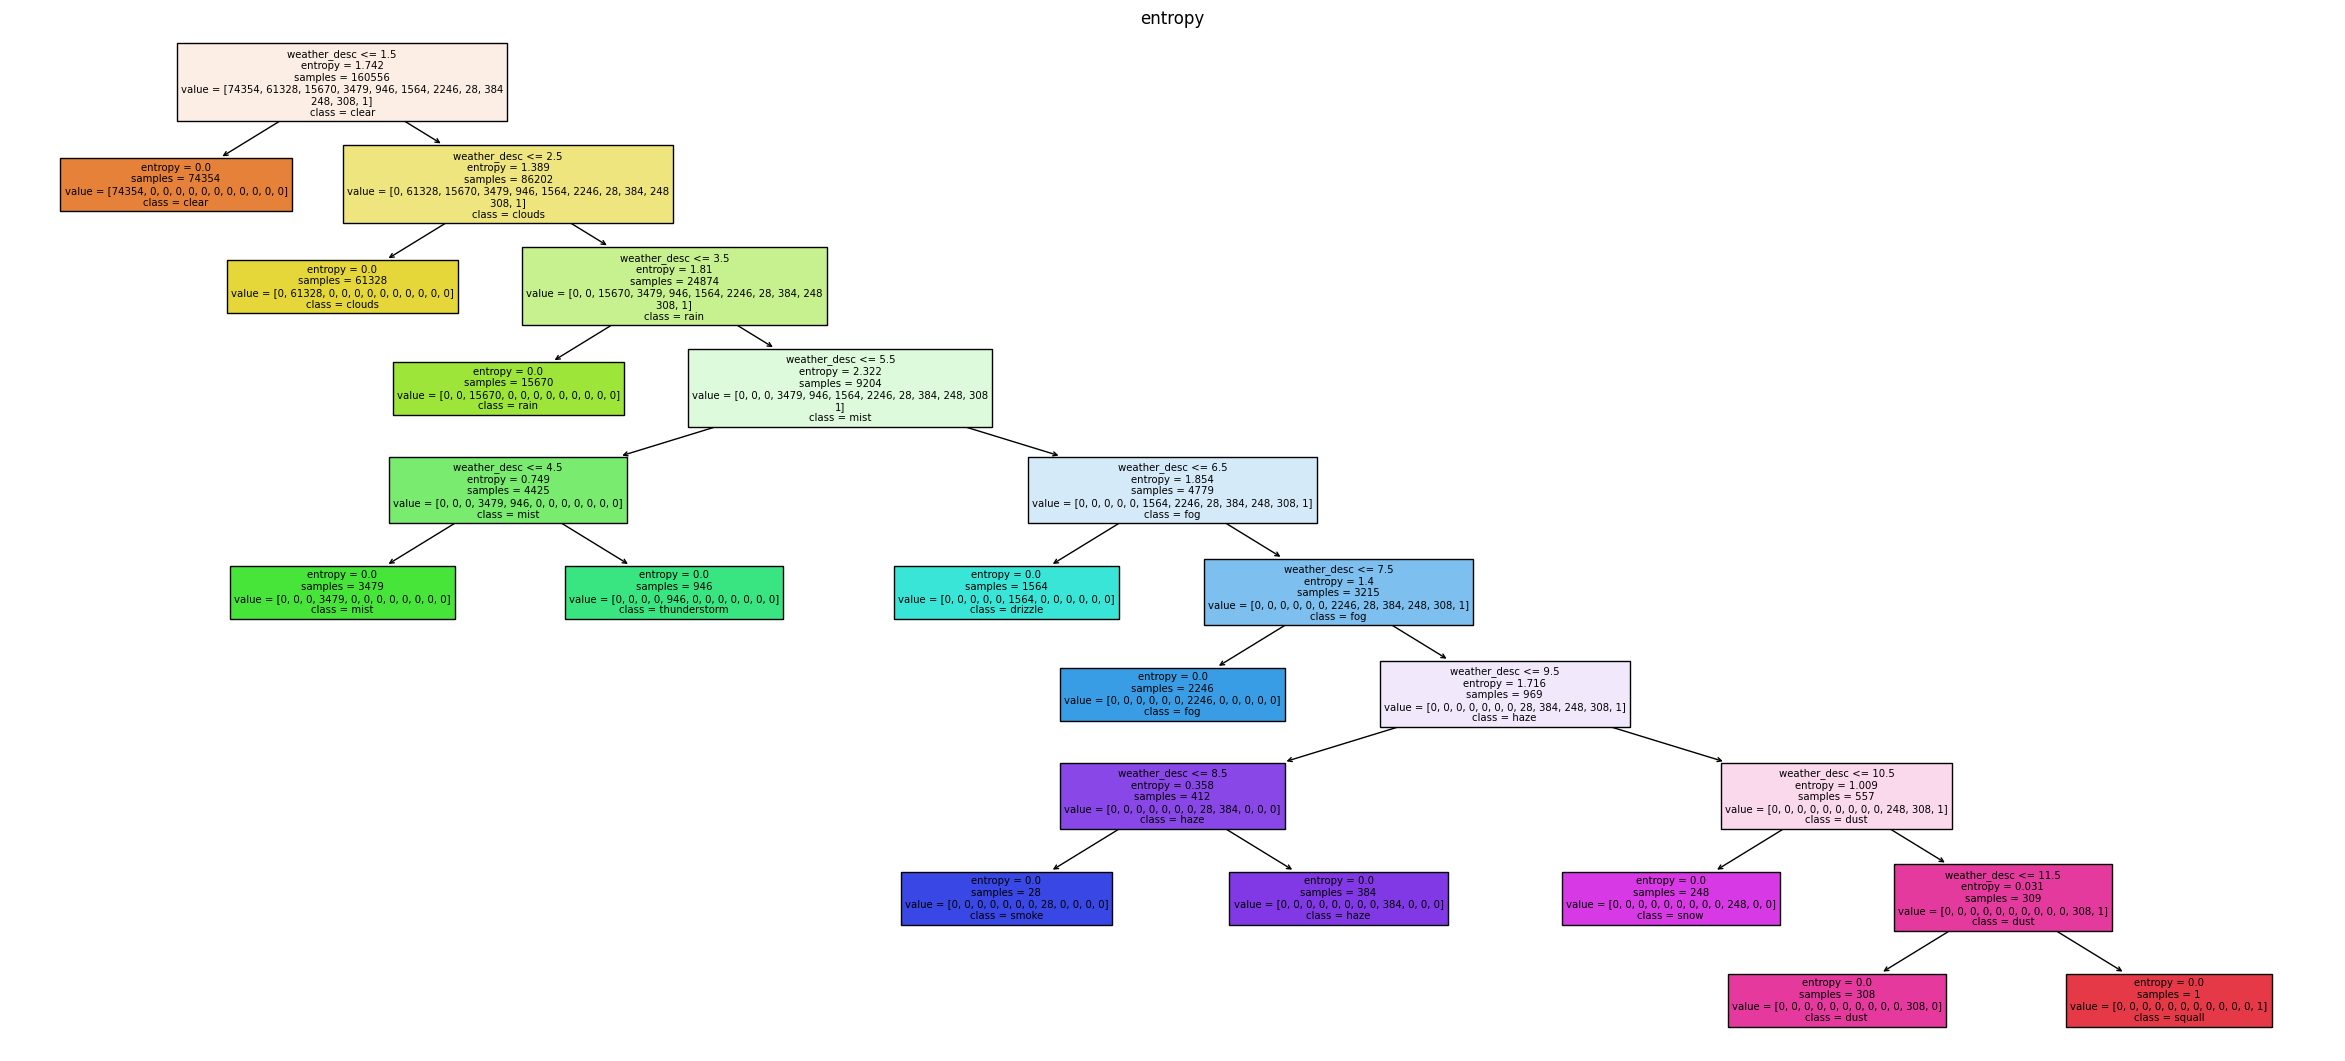

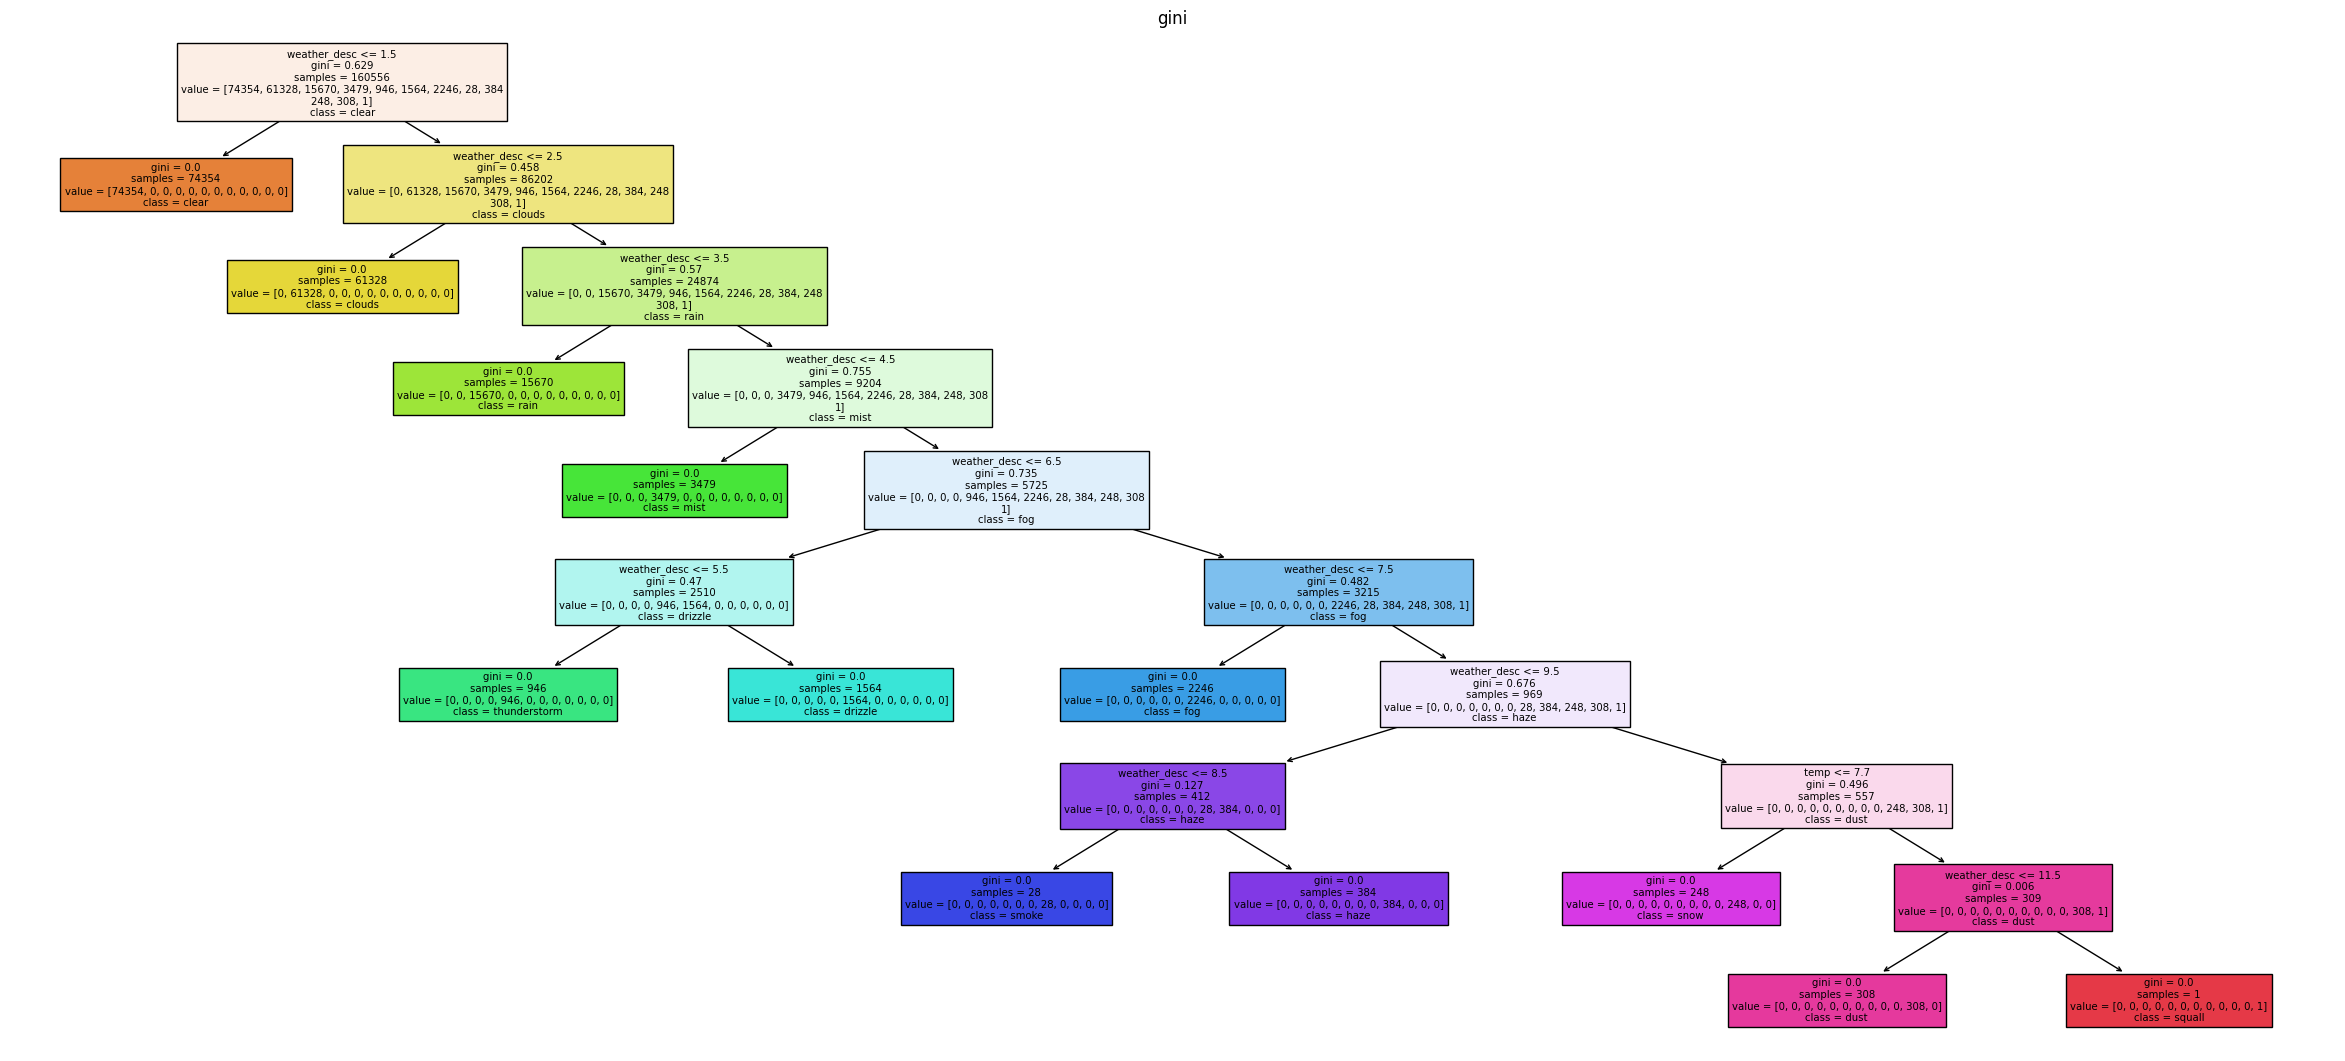

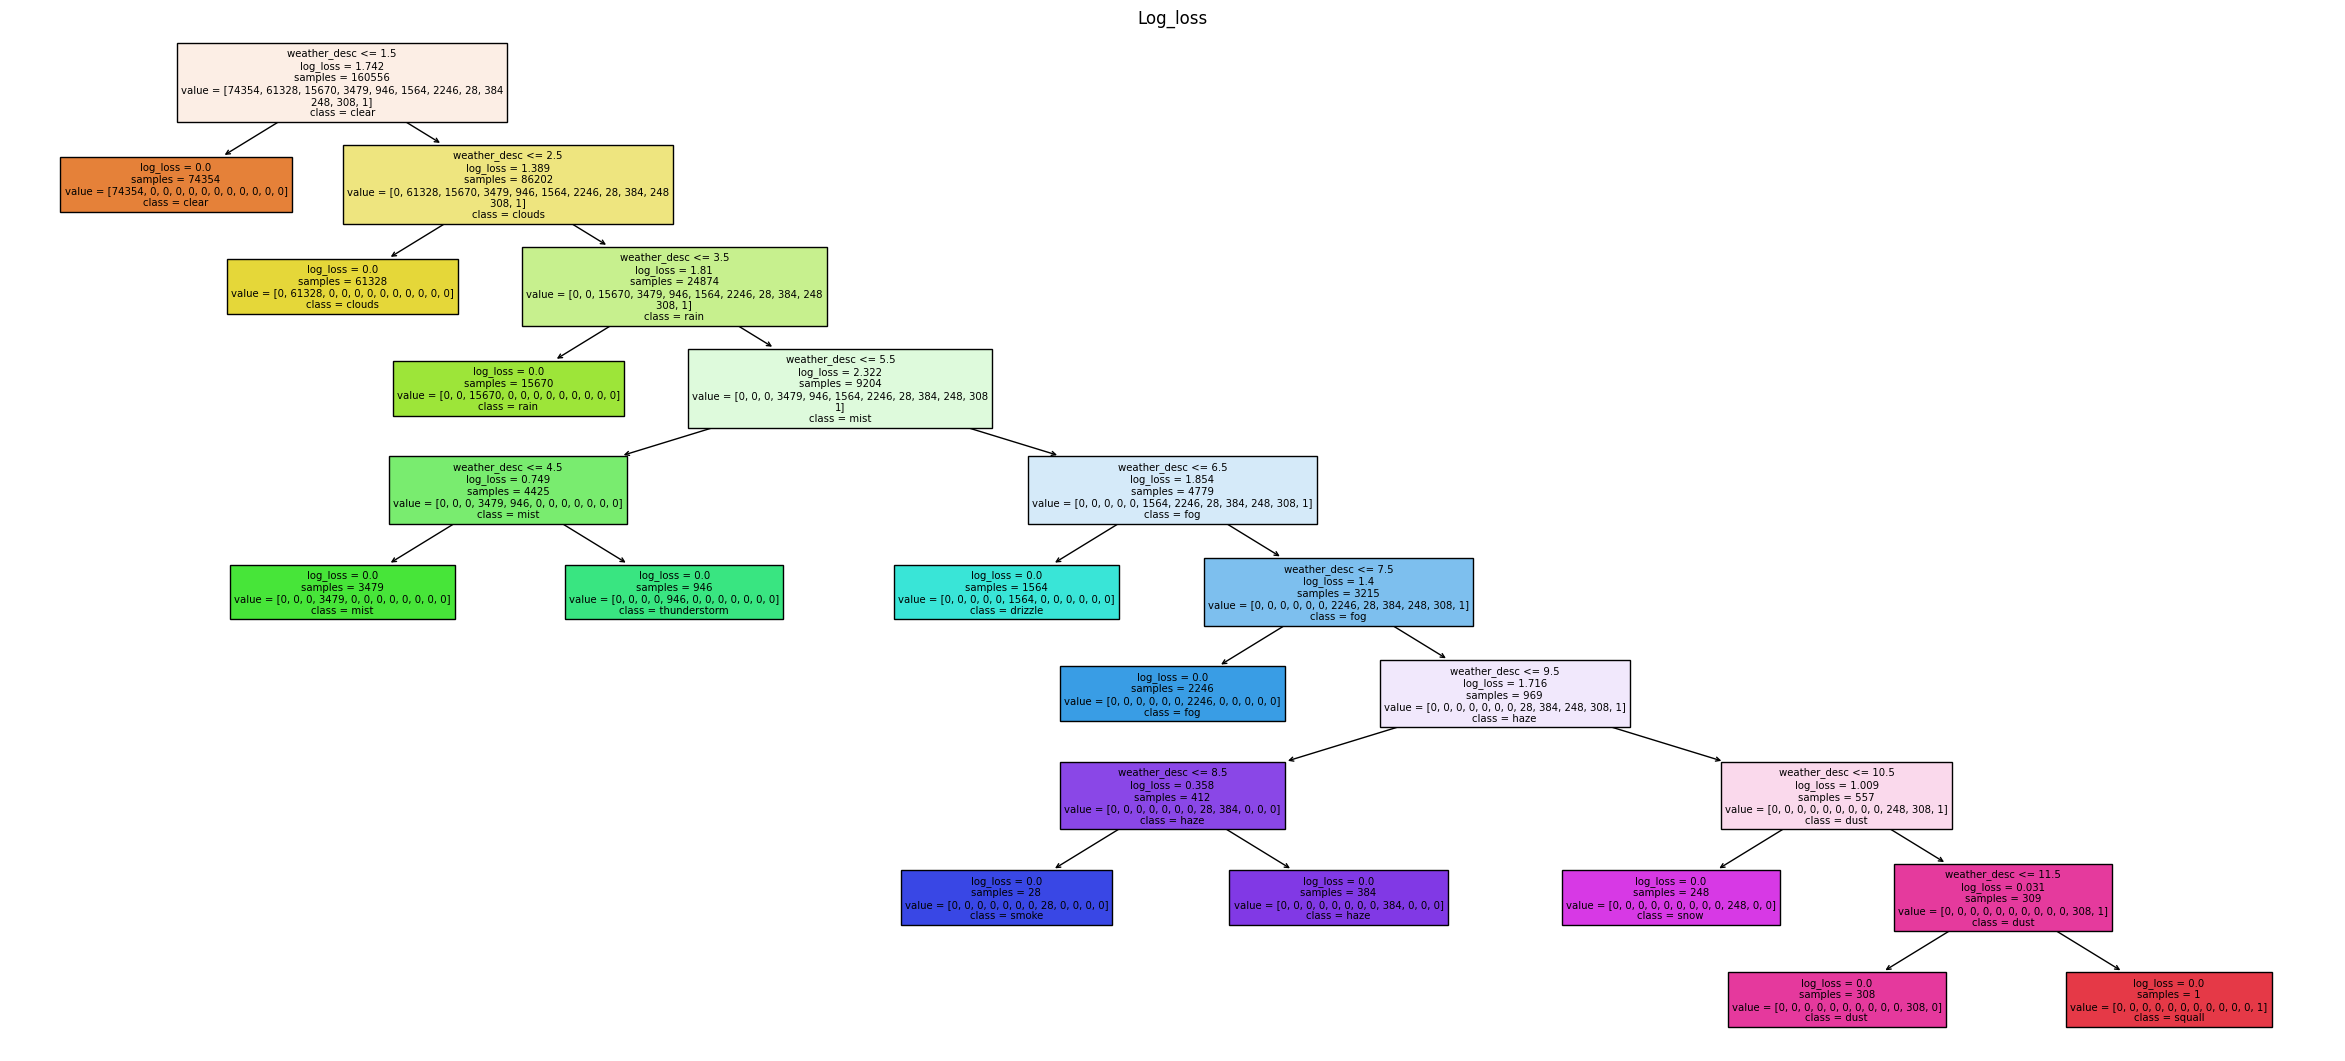

In [14]:
#Let's plot the remaining decision tree
fn= X.columns
cn=['clear', 'clouds','rain', 'mist','thunderstorm', 'drizzle','fog' , 'smoke',
'haze','snow', 'dust', 'squall']

index = 0

for key, classi in deci_tree.items():
    plt.figure(figsize=(30,45))
    ax = plt.subplot(3,1, index+1)
    
    tree.plot_tree(deci_tree[key], feature_names = fn, 
               class_names=cn,
               ax = ax,
               filled = True)
    ax.title.set_text(key)
    index = index+1

In [15]:
#Predict the response for test dataset
for key, classi in deci_tree.items():
    y_pred = deci_tree[key].predict(test_x)
    print("Accuracy for "+key+" :",accuracy_score(test_y, y_pred))

Accuracy for entropy : 1.0
Accuracy for gini : 1.0
Accuracy for Log_loss : 1.0


**Bagging Classifier**

Bagging is a technique that enhances the accuracy and stability of machine learning models by averaging multiple models trained on different subsets of data. This helps reduce variance and improve the model's generalization





In [16]:
from sklearn.ensemble import BaggingClassifier

trainAcc = []
testAcc = []
Bagging_Classifier = BaggingClassifier(n_estimators=100, random_state=40)
Bagging_Classifier.fit(train_x, train_y)

clf = BaggingClassifier(random_state=40)
clf.fit(train_x, train_y)
predictions_train = clf.predict(train_x)
predictions = clf.predict(test_x)

#Display accuracy
trainAcc.append(accuracy_score(train_y, predictions_train))
testAcc.append(accuracy_score(test_y, predictions))
predictions = Bagging_Classifier.predict(test_x)
accuracy = accuracy_score(test_y, predictions)
print(f"Model accuracy: {accuracy:.2f}")
print(classification_report(test_y, predictions))




Model accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8331
           1       1.00      1.00      1.00      6727
           2       1.00      1.00      1.00      1721
           3       1.00      1.00      1.00       429
           4       1.00      1.00      1.00        95
           5       1.00      1.00      1.00       160
           6       1.00      1.00      1.00       260
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00        51
           9       1.00      1.00      1.00        22
          10       1.00      1.00      1.00        39

    accuracy                           1.00     17840
   macro avg       1.00      1.00      1.00     17840
weighted avg       1.00      1.00      1.00     17840



**Random Forest Classifier**

While the Decision Tree focuses on constructing a single decision tree, the Random Forest employs multiple trees to enhance accuracy and reduce overfitting. This makes the Random Forest generally more robust, but sometimes it can be less interpretable than a single decision tree.


In [17]:
from sklearn.ensemble import RandomForestClassifier


random_forest = RandomForestClassifier(n_estimators=100, random_state=40)
random_forest.fit(train_x, train_y)

#Para mostrar accuracy
predictions = random_forest.predict(test_x)
predictions_train = random_forest.predict(train_x)
accuracy = accuracy_score(test_y, predictions)
print(f"Model accuracy: {accuracy:.2f}")
print(classification_report(test_y, predictions))

trainAcc.append(accuracy_score(train_y, predictions_train))
testAcc.append(accuracy_score(test_y, predictions))




Precisión del modelo: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8331
           1       1.00      1.00      1.00      6727
           2       1.00      1.00      1.00      1721
           3       1.00      1.00      1.00       429
           4       1.00      1.00      1.00        95
           5       0.97      0.99      0.98       160
           6       0.99      1.00      0.99       260
           7       1.00      0.40      0.57         5
           8       0.96      0.94      0.95        51
           9       1.00      1.00      1.00        22
          10       1.00      0.97      0.99        39

    accuracy                           1.00     17840
   macro avg       0.99      0.94      0.95     17840
weighted avg       1.00      1.00      1.00     17840




- **Precision**: It is the ratio of true positives to the total examples classified as positive.
- **Recall** (Sensitivity): It is the ratio of true positives to the total examples that are actually positive.
- **F1-score**: It is a harmonic mean between Precision and Recall, providing a balance between both metrics.
- **Support**: The number of examples in each true class in the test dataset.
- **Macro avg**: calculates averages without considering class imbalances.
- **Weighted avg**: takes into account the imbalance by weighting each class based on the number of samples

**Comparation**



The main difference between Bagging and Random Forest lies in the introduction of randomness in feature selection when constructing each decision tree in Random Forest. Random Forest uses Bagging as a key component but adds more variability by restricting the features considered at each tree split.

Better predictive performance on large and complex datasets -> Random Forest
Simplicity, interpretability -> Bagging

As we have a simple dataset without complexity, models generated by Bagging and Random Forest produce similar results

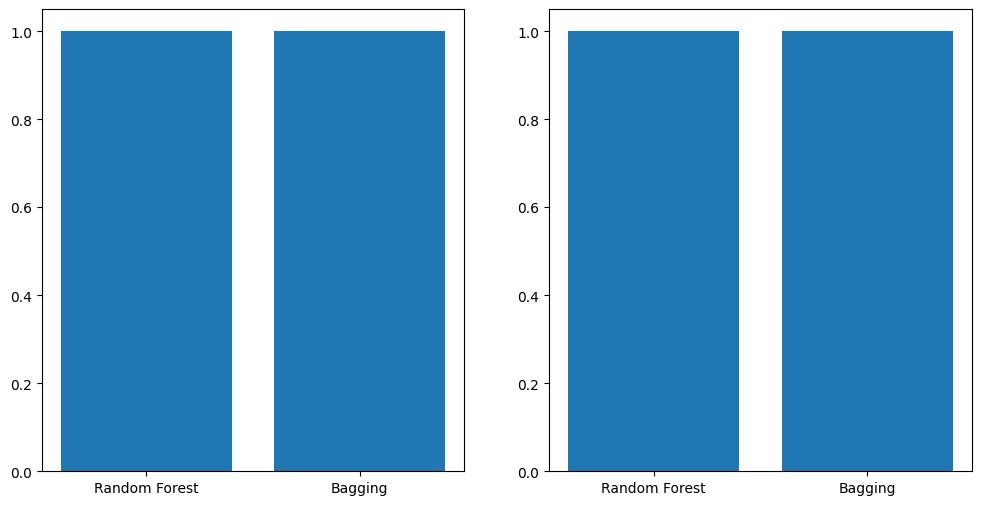

In [18]:
methods = ['Random Forest', 'Bagging']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.bar([1.5,2.5], trainAcc)
ax1.set_xticks([1.5,2.5])
ax1.set_xticklabels(methods)
ax2.bar([1.5,2.5], testAcc)
ax2.set_xticks([1.5,2.5])
ax2.set_xticklabels(methods)
plt.show()